# Torque estimation

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

train_data = np.genfromtxt('../data/david_bb_900g_5.txt', delimiter='\t', skip_header=3)

data_emg = train_data[:,0]
data_angle = 3.14-train_data[:,1]/1000

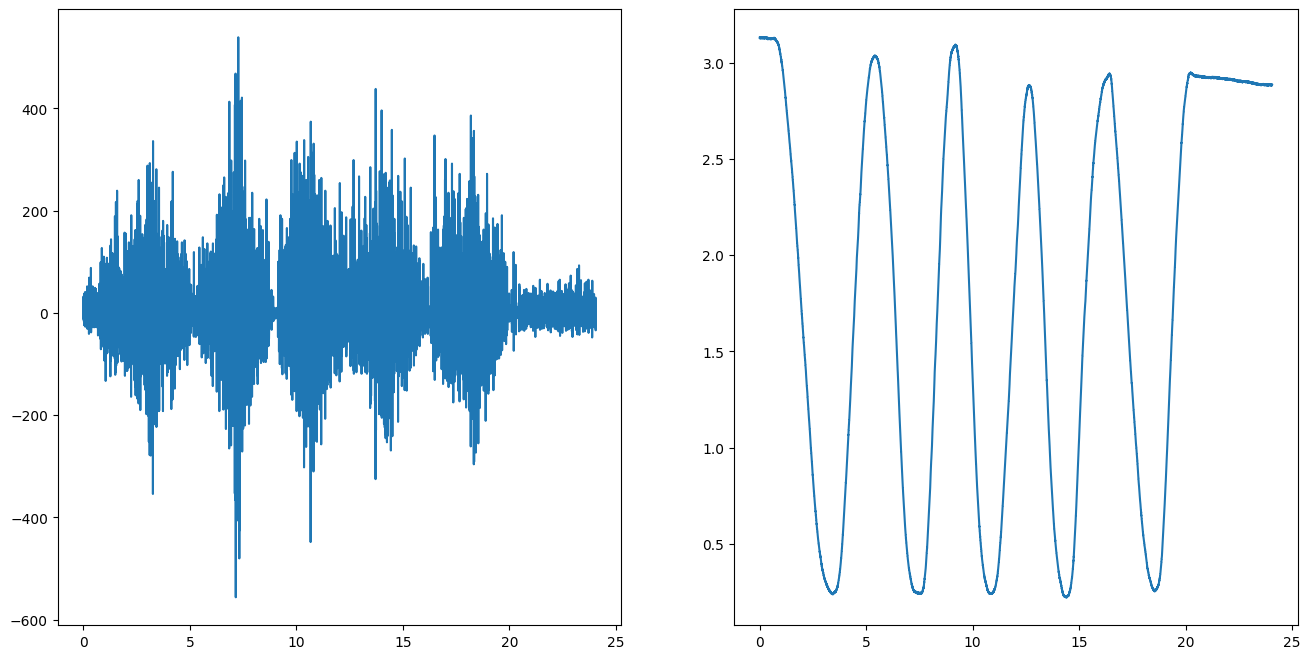

In [2]:
Ts = 1e-3;
t = np.linspace(0, len(train_data)*Ts, len(train_data))

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(t, data_emg)
ax[1].plot(t, data_angle)

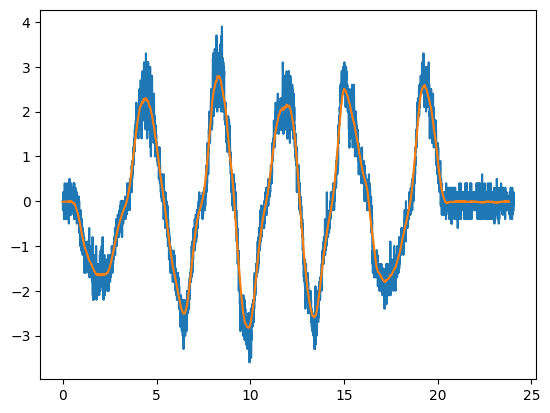

In [3]:
N = 100
step = 5

data_dangle = np.gradient(data_angle[::step],step*Ts)
plt.plot(t[::step], data_dangle)

data_dangle = np.convolve(data_dangle, np.ones(N)/N, mode='valid')
data_dangle = np.interp(t[:], np.convolve(t[::step], np.ones(N)/N, mode='valid'), data_dangle)
plt.plot(t, data_dangle)

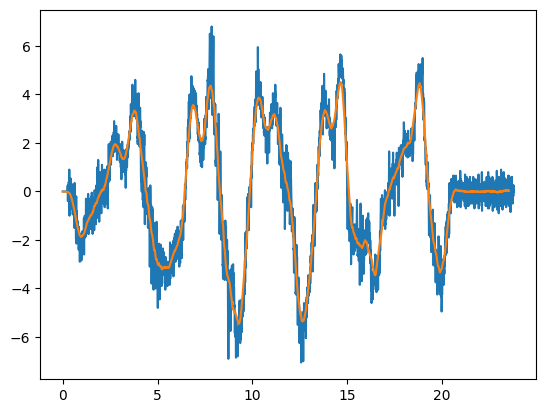

In [4]:
data_ddangle = np.gradient(data_dangle[::step],step*Ts)
plt.plot(t[::step], data_ddangle)

data_ddangle = np.convolve(data_ddangle, np.ones(N)/N, mode='valid')
data_ddangle = np.interp(t[:],np.convolve(t[::step], np.ones(N)/N, mode='valid'),data_ddangle)
plt.plot(t[:], data_ddangle)

In [5]:
def get_angle_dynamics(data_angle, N=N, step=step, Ts=Ts):
    t = np.linspace(0, len(data_angle)*Ts, len(data_angle))
    data_dangle = np.gradient(data_angle[::step],step*Ts)
    data_dangle = np.convolve(data_dangle, np.ones(N)/N, mode='valid')
    data_dangle = np.interp(t[:], np.convolve(t[::step], np.ones(N)/N, mode='valid'), data_dangle)
    
    data_ddangle = np.gradient(data_dangle[::step],step*Ts)
    data_ddangle = np.convolve(data_ddangle, np.ones(N)/N, mode='valid')
    data_ddangle = np.interp(t[:],np.convolve(t[::step], np.ones(N)/N, mode='valid'),data_ddangle)

    return data_dangle, data_ddangle

## Parameters

In [6]:
body_mass = 74 # Subject mass in kilograms

m = 2.52/100 * body_mass # Mass of forearm and arm (source: https://exrx.net/Kinesiology/Segments)
w = 900e-3 # Mass of the load
l = 30e-2 # Distance from elbow to center of hand
l_cm = 0.43*l # Distance from elbow to forearm center of mass
J = 1/3*m*l**2 # Moment of inertia (cylinder rotating abount an end)
g = 9.81 # Gravitational acceleration
beta = 0.4 # Joint friction

## Experimental torque

In [7]:
def get_torque(angle, dangle, ddangle, load=0):
    w = load
    return ((m+w)*l_cm**2+J)*ddangle+beta*dangle+(m*l_cm+w*l)*g*np.sin(angle)

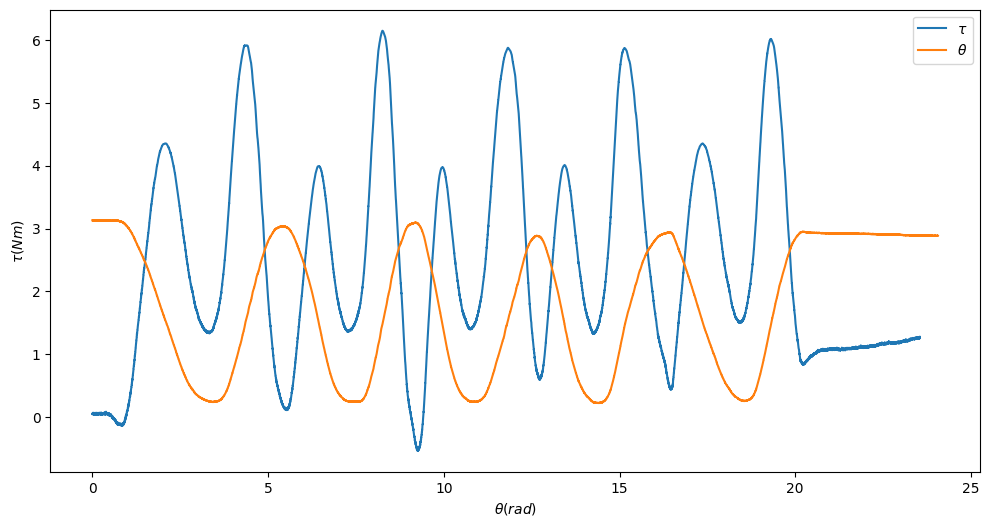

In [8]:
data_torque = np.array([get_torque(a, da, dda, w) for (a,da,dda) in zip(data_angle[:],data_dangle[:],data_ddangle)])

plt.figure(figsize=(12,6))
plt.plot(t[:], data_torque, label=r"$\tau$")
plt.plot(t, data_angle, label=r"$\theta$")
plt.ylabel(r"$\tau (Nm)$")
plt.xlabel(r"$\theta (rad)$")
plt.legend()
plt.savefig("../images/torque_from_angle.png")

## EMG Preprocessing

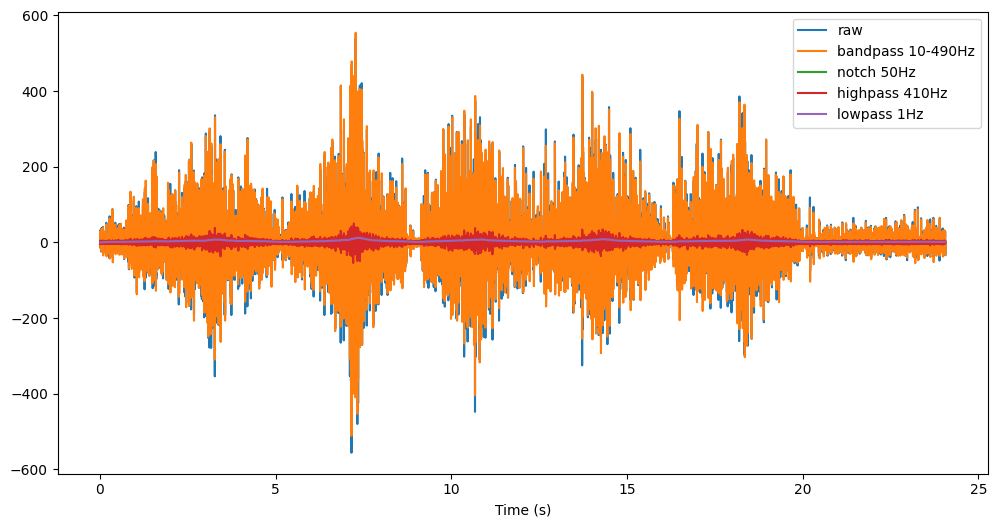

In [9]:
def rms(signal: np.ndarray, wl: int, wi: int):
    return np.array([np.sqrt(np.sum(signal[i*wi:i*wi+wl]**2)/wl) 
                for i in range(len(signal)//wi)])

def preprocess(data_emg, debug=False, max_semg_val=0):
    t = np.linspace(0, Ts*len(data_emg), len(data_emg))
    if debug:
        plt.figure(figsize=(12,6))
        plt.plot(t, data_emg, label="raw")
    
    sos = scipy.signal.butter(2, [10, 490], 'bandpass', fs=1/Ts, output='sos') # Butterworth order 2 band-pass filter (10-490 Hz)
    emg = scipy.signal.sosfilt(sos, data_emg) 
    if debug:
        plt.plot(t, emg, label="bandpass 10-490Hz")

    b, a = scipy.signal.iirnotch(w0=50, Q=30, fs=1/Ts) # 50Hz notch filter
    emg = scipy.signal.filtfilt(b, a, emg)
    if debug:
        plt.plot(t, emg, label="notch 50Hz")
    
    sos = scipy.signal.butter(1, 410, 'highpass', fs=1/Ts, output='sos') # Butterworth order 1 high-pass filter (410 Hz cutoff)
    emg = scipy.signal.sosfilt(sos, data_emg) 
    if debug:
        plt.plot(t, emg, label="highpass 410Hz")

    emg = np.abs(emg) # Full wave rectification
    
    sos = scipy.signal.butter(1, 1, fs=1/Ts, output='sos') # Butterworth order 1 low-pass filter (1 Hz cutoff)
    emg = scipy.signal.sosfilt(sos, emg) 
    if debug:
        plt.plot(t, emg, label="lowpass 1Hz")
        plt.xlabel("Time (s)")
        plt.legend()
        plt.savefig("../images/processing.png")
    
    emg *= 1/max(max(emg), max_semg_val)
    return t, emg

t, emg = preprocess(data_emg, debug=True)

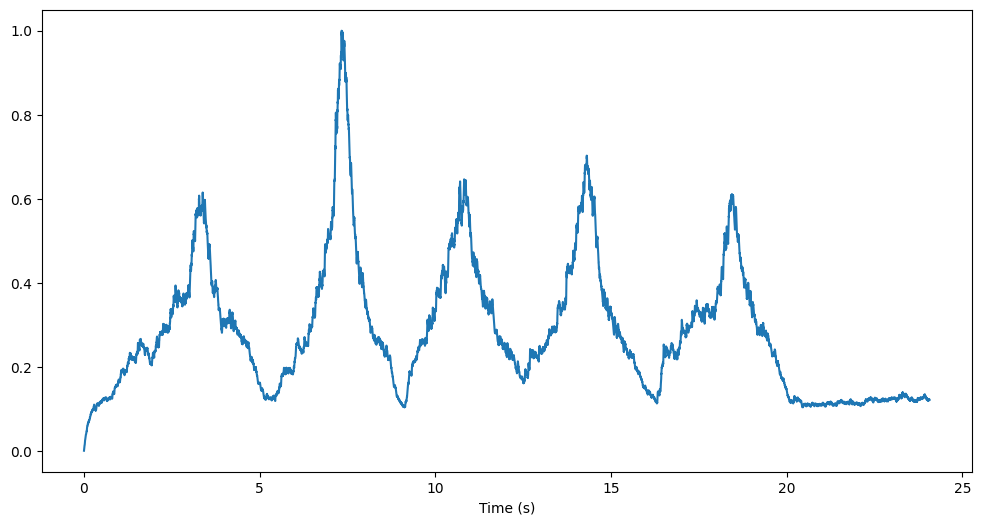

In [28]:
plt.figure(figsize=(12,6))
plt.plot(t, emg)
plt.xlabel("Time (s)")
plt.savefig("../images/processed.png")

## Deep learning
### Model training

In [11]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Add
from tensorflow.keras.optimizers import Adam

def format_emg(emg):
    return np.array([(e1, e2, e3) for (e1, e2, e3) in zip(emg[:-2],emg[1:-1],emg[2:])])

def format_angles(angles):
    return np.array([np.mean([a1,a2,a3]) for (a1,a2,a3) in zip(angles[:-2], angles[1:-1], angles[2:])])

def train_models():
    open_model = Sequential()
    open_model.add(Dense(units=16, input_shape=(3,), activation='relu'))
    open_model.add(Dense(units=1, activation='linear'))
    open_model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
    
    closed_model = Sequential()
    closed_model.add(Dense(units=16, input_shape=(4,), activation='relu'))
    closed_model.add(Dense(units=1, activation='linear'))
    closed_model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
        
    emg_train, torque_train = emg[::40], data_torque[::40]
    emg_train = format_emg(emg_train)  # Consider 3 consecutive data points as input
    open_model.fit(emg_train, torque_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=0)
    
    angle_train = format_angles(data_angle[::40])
    train_data = np.concatenate((emg_train, angle_train.reshape(len(angle_train),1)), axis=1)
    closed_model.fit(train_data, torque_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=0)
    return open_model, closed_model

2024-03-28 10:19:04.560588: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 10:19:05.053728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 10:19:05.053806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 10:19:05.094269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 10:19:05.197858: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 10:19:05.198197: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [12]:
open_model = keras.models.load_model("../models/open_model.keras")
closed_model = keras.models.load_model("../models/closed_model.keras")
# open_model, closed_model = train_models()

### Model test

In [13]:
def get_data(path):
    return np.genfromtxt(path, delimiter='\t', skip_header=3)

def evaluate_open_model(path, model, load=0, debug=False, max_semg_val=0):
    test_data = get_data(path)
    t = np.linspace(0, len(test_data)*Ts, len(test_data))
    data_emg = test_data[:,0]
    data_angle = 3.14-test_data[:,1]/1000

    if debug:
        fig, ax = plt.subplots(1,2, figsize=(16,8))
        ax[0].plot(t, data_emg)
        ax[1].plot(t, data_angle)
    
    data_dangle, data_ddangle = get_angle_dynamics(data_angle)
    test_torque = get_torque(data_angle, data_dangle, data_ddangle, load=load)
    t, test_emg = preprocess(data_emg, max_semg_val=max_semg_val)
    test_emg=test_emg[::40]
    test_emg = format_emg(test_emg)

    predicted_torque = model.predict(test_emg).reshape(-1)
    
    return t[::40][1:-1], test_torque[::40][1:-1], predicted_torque
    
def evaluate_closed_model(path, model, load=0, debug=False, max_semg_val=0):
    test_data = get_data(path)
    t = np.linspace(0, len(test_data)*Ts, len(test_data))
    data_emg = test_data[:,0]
    data_angle = 3.14-test_data[:,1]/1000

    if debug:
        fig, ax = plt.subplots(1,2, figsize=(16,8))
        ax[0].plot(t, data_emg)
        ax[1].plot(t, data_angle)
    
    data_dangle, data_ddangle = get_angle_dynamics(data_angle)
    test_torque = get_torque(data_angle, data_dangle, data_ddangle, load=load)
    t, test_emg = preprocess(data_emg, max_semg_val=max_semg_val)
    test_emg=test_emg[::40]
    test_emg = format_emg(test_emg)

    angle_test = format_angles(data_angle[::40])
    test_data = np.concatenate((test_emg, angle_test.reshape(len(angle_test),1)), axis=1)
    predicted_torque = model.predict(test_data).reshape(-1)
    
    return t[::40][1:-1], test_torque[::40][1:-1], predicted_torque

35/35 [==============================] - 0s 2ms/step


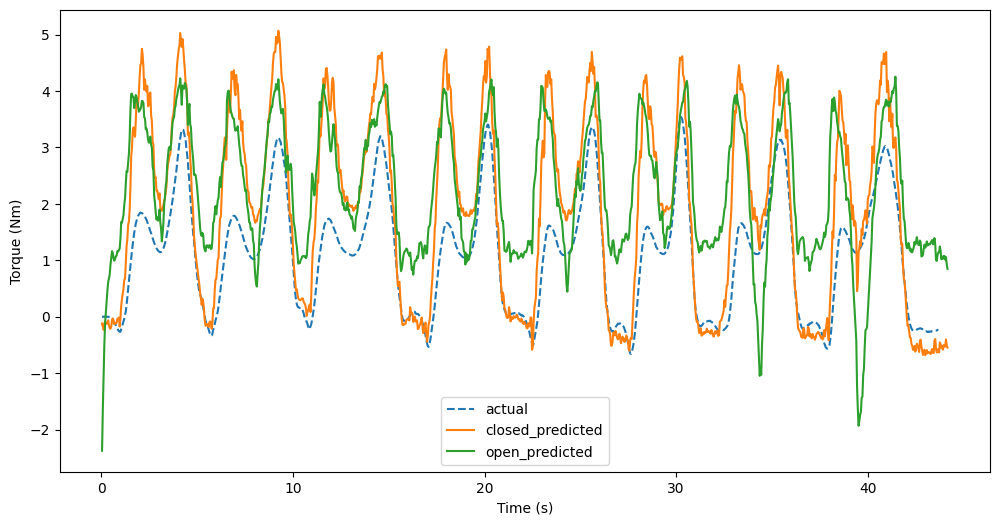

In [14]:
data_to_compare = '../data/david_bb_0g_7.txt'
t1, test_torque1, predicted_torque1 = evaluate_closed_model(data_to_compare, closed_model, load=0)
t2, test_torque2, predicted_torque2 = evaluate_open_model(data_to_compare, open_model, load=0)

plt.figure(figsize=(12,6))
plt.plot(t1, test_torque1, "--",label="actual")
plt.plot(t1, predicted_torque1, label="closed_predicted")
plt.plot(t2, predicted_torque2, label="open_predicted")
plt.ylabel("Torque (Nm)")
plt.xlabel("Time (s)")
plt.legend()
plt.savefig("../images/open_vs_closed_0g.png")

29/29 [==============================] - 0s 3ms/step


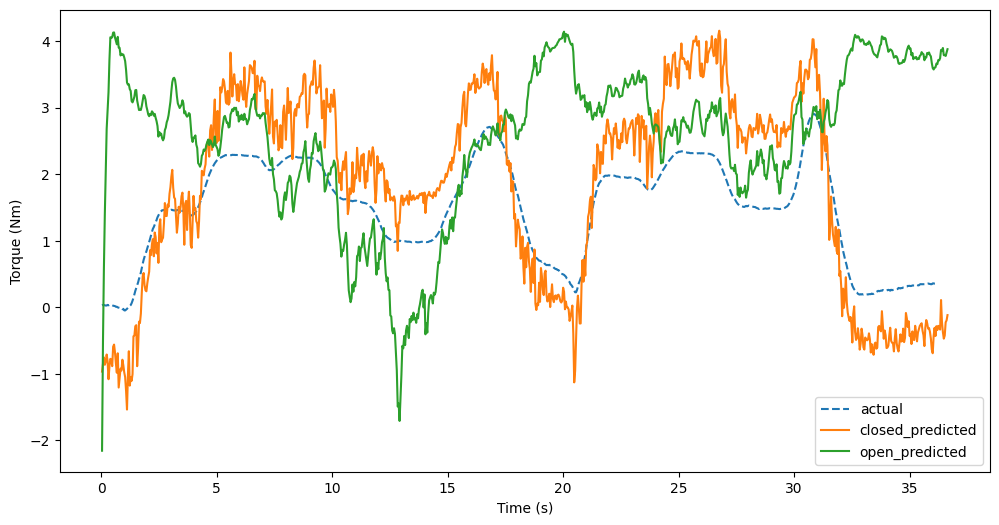

In [15]:
data_to_compare = '../data/david_bb_900g_2_with_stops.txt'
t1, test_torque1, predicted_torque1 = evaluate_closed_model(data_to_compare, closed_model, load=0)
t2, test_torque2, predicted_torque2 = evaluate_open_model(data_to_compare, open_model, load=0)

plt.figure(figsize=(12,6))
plt.plot(t1, test_torque1, "--",label="actual")
plt.plot(t1, predicted_torque1, label="closed_predicted")
plt.plot(t2, predicted_torque2, label="open_predicted")
plt.ylabel("Torque (Nm)")
plt.xlabel("Time (s)")
plt.legend()
plt.savefig("../images/open_vs_closed_0g_stops.png")

31/31 [==============================] - 0s 2ms/step


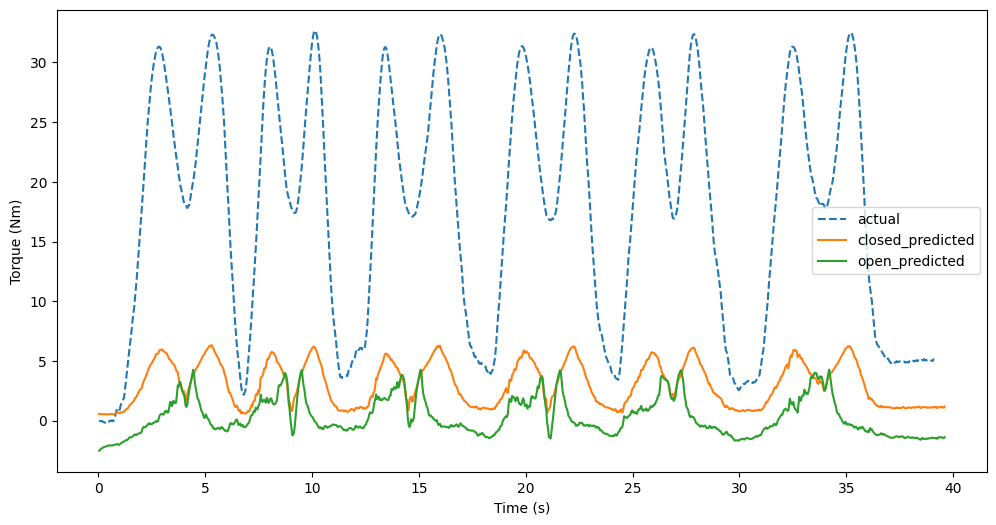

In [16]:
data_to_compare = '../data/david_bb_10kg_5.txt'
t1, test_torque1, predicted_torque1 = evaluate_closed_model(data_to_compare, closed_model, load=10)
t2, test_torque2, predicted_torque2 = evaluate_open_model(data_to_compare, open_model, load=10)

plt.figure(figsize=(12,6))
plt.plot(t1, test_torque1, "--",label="actual")
plt.plot(t1, predicted_torque1, label="closed_predicted")
plt.plot(t2, predicted_torque2, label="open_predicted")
plt.ylabel("Torque (Nm)")
plt.xlabel("Time (s)")
plt.legend()
plt.savefig("../images/open_vs_closed_10kg.png")

9/9 [==============================] - 0s 3ms/step


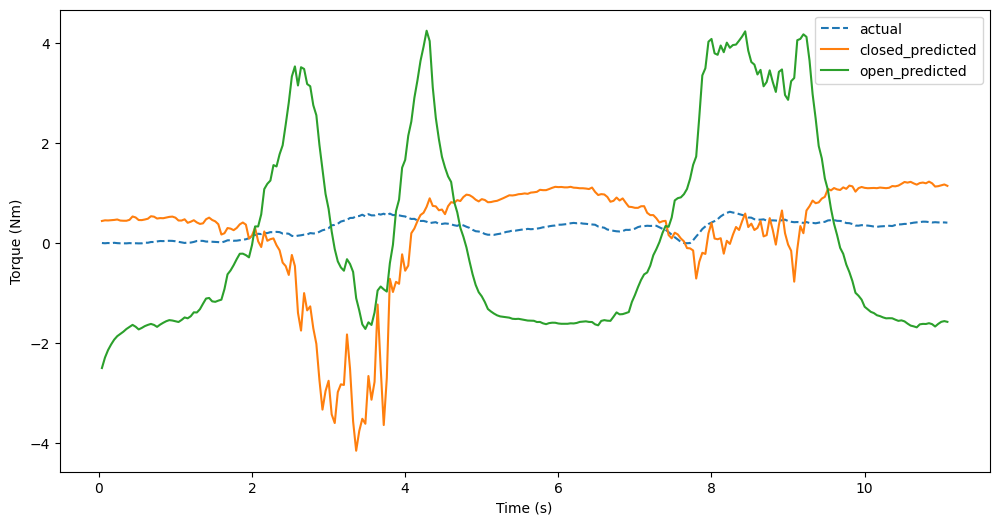

In [17]:
data_to_compare = '../data/david_too_heavy.txt'
t1, test_torque1, predicted_torque1 = evaluate_closed_model(data_to_compare, closed_model)
t2, test_torque2, predicted_torque2 = evaluate_open_model(data_to_compare, open_model)

plt.figure(figsize=(12,6))
plt.plot(t1, test_torque1, "--",label="actual")
plt.plot(t1, predicted_torque1, label="closed_predicted")
plt.plot(t2, predicted_torque2, label="open_predicted")
plt.ylabel("Torque (Nm)")
plt.xlabel("Time (s)")
plt.legend()
plt.savefig("../images/open_vs_closed_too_heavy.png")

## Save models

In [18]:
open_model.save('../models/open_model.keras')
closed_model.save('../models/closed_model.keras')

## Multi-dataset model

In [19]:
datasets = dict({
            "../data/david_bb_900g_2_with_stops.txt":0.9,
            "../data/david_bb_900g_5.txt":0.9,
            "../data/david_bb_10kg_5.txt":10,
            "../data/david_bb_0g.txt":0,
            "../data/david_bb_0g_faster.txt":0})

In [20]:
all_emg = []
all_torque = []
all_angles = []
max_emg = 0

for data, load in datasets.items():
    train_data = np.genfromtxt(data, delimiter='\t', skip_header=3)
    data_emg = train_data[:,0]
    max_emg = max(max_emg, max(np.abs(data_emg)))
    all_emg.append(data_emg)
    data_angle = 3.14-train_data[:,1]/1000
    all_angles.append(data_angle)
    data_dangle, data_ddangle = get_angle_dynamics(data_angle)
    all_torque.append(get_torque(data_angle, data_dangle, data_ddangle, load=load))

In [21]:
def train_multi_models():
    multi_open_model = Sequential()
    multi_open_model.add(Dense(units=16, input_shape=(3,), activation='relu'))
    multi_open_model.add(Dense(units=1, activation='linear'))
    multi_open_model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
    
    multi_closed_model = Sequential()
    multi_closed_model.add(Dense(units=16, input_shape=(4,), activation='relu'))
    multi_closed_model.add(Dense(units=1, activation='linear'))
    multi_closed_model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
    
    for emg, torque, angle in zip(all_emg, all_torque, all_angles):
        _, emg = preprocess(emg, max_semg_val=max_emg)
        emg_train, torque_train = emg[::40], torque[::40]
        emg_train = format_emg(emg_train)
        multi_open_model.fit(emg_train, torque_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=0)
        
        angle_train = format_angles(angle[::40])
        train_data = np.concatenate((emg_train, angle_train.reshape(len(angle_train),1)), axis=1)
        multi_closed_model.fit(train_data, torque_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=0)
    
    return multi_open_model, multi_closed_model

In [22]:
multi_open_model = keras.models.load_model("../models/multi_open_model.keras")
multi_closed_model = keras.models.load_model("../models/multi_closed_model.keras")
# multi_open_model, multi_closed_model = train_multi_models()

35/35 [==============================] - 0s 2ms/step


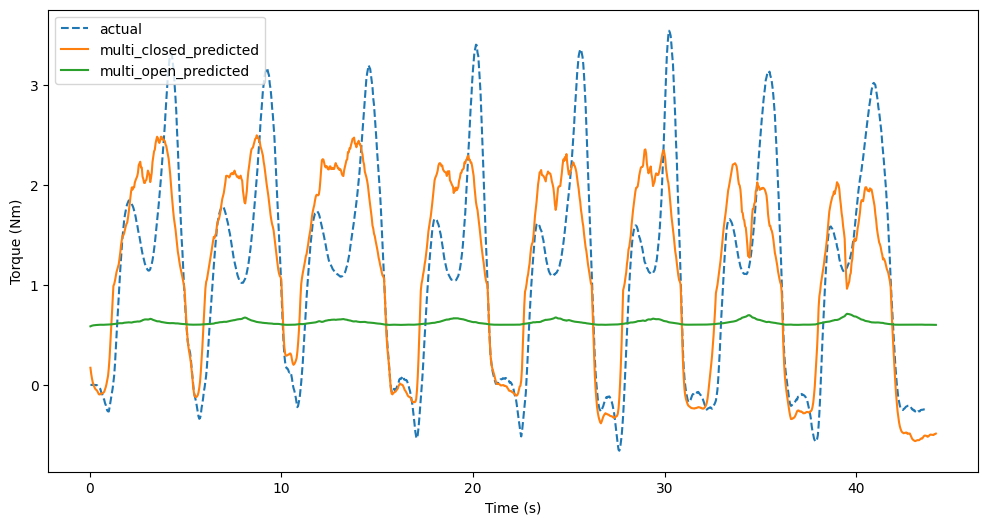

In [23]:
data_to_compare = '../data/david_bb_0g_7.txt'
t1, test_torque1, predicted_torque1 = evaluate_closed_model(data_to_compare, multi_closed_model, max_semg_val=max_emg)
t2, test_torque2, predicted_torque2 = evaluate_open_model(data_to_compare, multi_open_model, max_semg_val=max_emg)

plt.figure(figsize=(12,6))
plt.plot(t1, test_torque1, "--",label="actual")
plt.plot(t1, predicted_torque1, label="multi_closed_predicted")
plt.plot(t2, predicted_torque2, label="multi_open_predicted")
plt.ylabel("Torque (Nm)")
plt.xlabel("Time (s)")
plt.legend()
plt.savefig("../images/multi_open_vs_closed_0g.png")

31/31 [==============================] - 0s 2ms/step


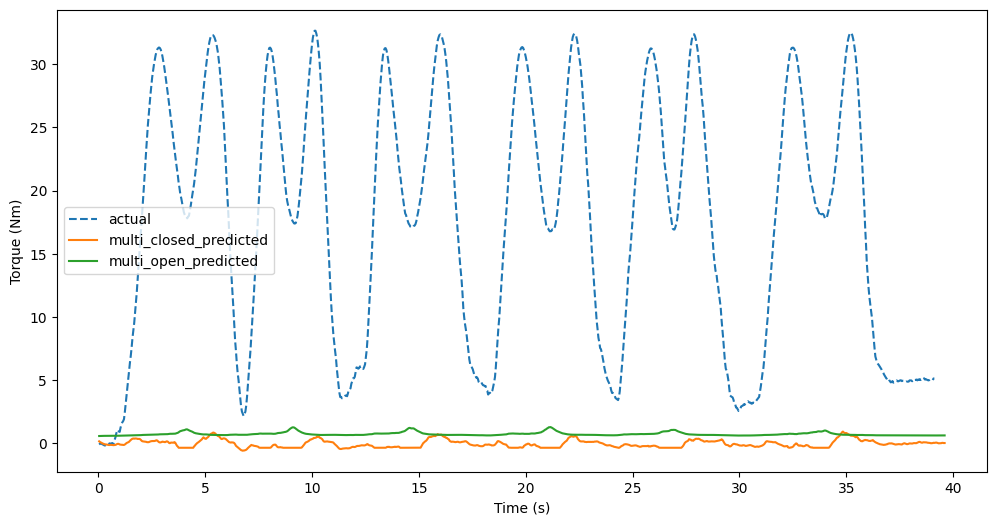

In [24]:
data_to_compare = '../data/david_bb_10kg_5.txt'
t1, test_torque1, predicted_torque1 = evaluate_closed_model(data_to_compare, multi_closed_model, load=10, max_semg_val=max_emg)
t2, test_torque2, predicted_torque2 = evaluate_open_model(data_to_compare, multi_open_model, load=10, max_semg_val=max_emg)

plt.figure(figsize=(12,6))
plt.plot(t1, test_torque1, "--",label="actual")
plt.plot(t1, predicted_torque1, label="multi_closed_predicted")
plt.plot(t2, predicted_torque2, label="multi_open_predicted")
plt.ylabel("Torque (Nm)")
plt.xlabel("Time (s)")
plt.legend()
plt.savefig("../images/multi_open_vs_closed_10kg.png")

29/29 [==============================] - 0s 3ms/step


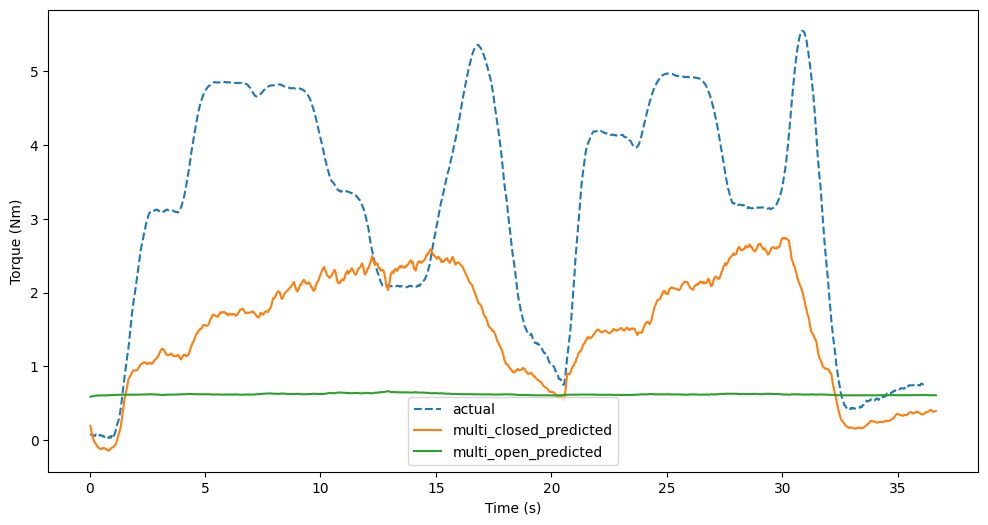

In [25]:
data_to_compare = '../data/david_bb_900g_2_with_stops.txt'
t1, test_torque1, predicted_torque1 = evaluate_closed_model(data_to_compare, multi_closed_model, load=0.9, max_semg_val=max_emg)
t2, test_torque2, predicted_torque2 = evaluate_open_model(data_to_compare, multi_open_model, load=0.9, max_semg_val=max_emg)

plt.figure(figsize=(12,6))
plt.plot(t1, test_torque1, "--",label="actual")
plt.plot(t1, predicted_torque1, label="multi_closed_predicted")
plt.plot(t2, predicted_torque2, label="multi_open_predicted")
plt.ylabel("Torque (Nm)")
plt.xlabel("Time (s)")
plt.legend()
plt.savefig("../images/multi_open_vs_closed_stops.png")

9/9 [==============================] - 0s 2ms/step


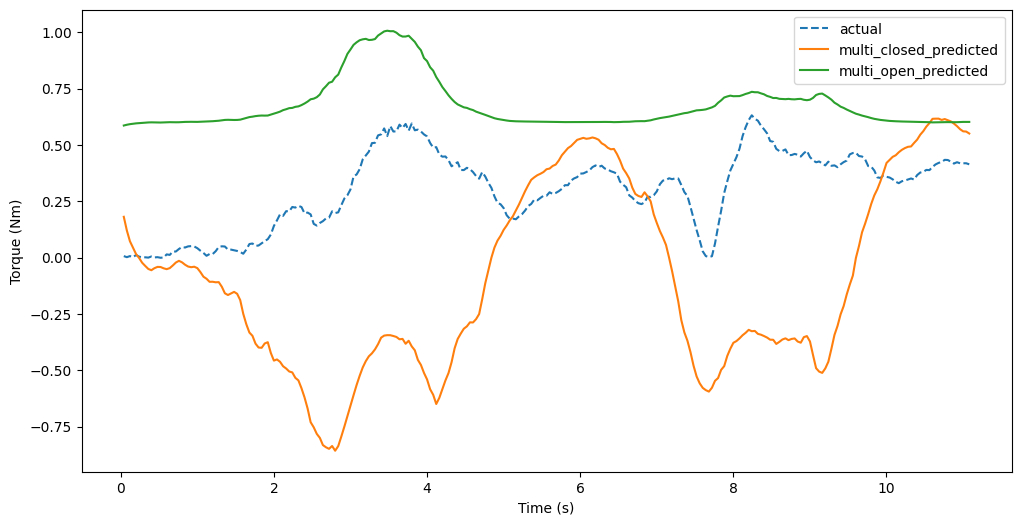

In [26]:
data_to_compare = '../data/david_too_heavy.txt'
t1, test_torque1, predicted_torque1 = evaluate_closed_model(data_to_compare, multi_closed_model, max_semg_val=max_emg)
t2, test_torque2, predicted_torque2 = evaluate_open_model(data_to_compare, multi_open_model, max_semg_val=max_emg)

plt.figure(figsize=(12,6))
plt.plot(t1, test_torque1, "--",label="actual")
plt.plot(t1, predicted_torque1, label="multi_closed_predicted")
plt.plot(t2, predicted_torque2, label="multi_open_predicted")
plt.ylabel("Torque (Nm)")
plt.xlabel("Time (s)")
plt.legend()
plt.savefig("../images/multi_open_vs_closed_too_heavy.png")

In [27]:
multi_closed_model.save('../models/multi_closed_model.keras')
multi_open_model.save('../models/multi_open_model.keras')